## ARIMA Models in Python

Source : Datacamp, James Fulton :Climate Informatics Researcher


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA

### 1:  Intro to time series and stationarity

#### 1 A: - Exploration
In this exercise you will kick off your journey to become an ARIMA master by loading and plotting a time series. You probably do this all the time, but this is just a refresher.

You will be exploring a dataset of monthly US candy production between 1972 and 2018.

Specifically, you are plotting the industrial production index IPG3113N. This is total amount of sugar and confectionery products produced in the USA per month, as a percentage of the January 2012 production. So 120 would be 120% of the January 2012 industrial production.

Check out how this quantity has changed over time and how it changes throughout the year.

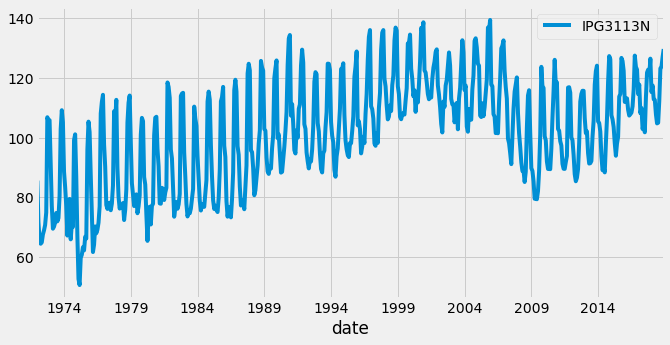

In [4]:
# Load in the candy production time series 'candy_production.csv' using pandas, set the index to the'date'column, 
#parse the dates and assign it to the variable candy.
candy = pd.read_csv("./dataset/candy_production.csv", index_col="date", parse_dates=True)

# Plot the time series onto the axis ax1 using the DataFrame's .plot() method. Then show the plot.
fig, ax = plt.subplots()
candy.plot(ax=ax)
plt.show()

note: Sweet work! This plotting method will be invaluable later when plotting multiple things on the same axis! Can you tell whether this is a stationary time series or not? How does it change throughout the year and across many years?

#### 1 : B - Train-test splits
In this exercise you are going to take the candy production dataset and split it into a train and a test set. Like you understood in the video exercise, the reason to do this is so that you can test the quality of your model fit when you are done

<AxesSubplot:xlabel='date'>

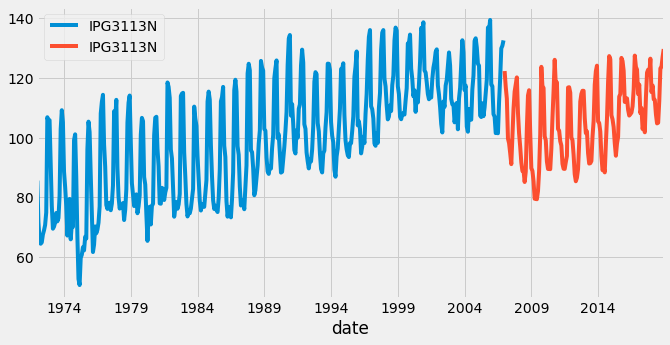

In [5]:
# Split the time series into train and test sets by slicing with datetime indexes.
    #Take the train set as everything up to the end of 2006 and the test set as everything from the start of 2007.
candy_train = candy.loc[:"2006"]
candy_test = candy.loc["2007":]

# Make a pyplot axes using the subplots() function.
fix, ax = plt.subplots()
# Use the DataFrame's .plot() method to plot the train and test sets on the axis ax.
candy_train.plot(ax=ax)
candy_test.plot(ax=ax)

note: Great! Take a look at the plot, do you think that you yourself could predict what happens after 2006 given the blue training set. What happens to the long term trend and the seasonal pattern?

#### 1 C: - Is it stationary
Identifying whether a time series is stationary or non-stationary is very important. If it is stationary you can use ARMA models to predict the next values of the time series. If it is non-stationary then you cannot use ARMA models, however, as you will see in the next lesson, you can often transform non-stationary time series to stationary ones.

In this exercise you will examine some stock and earthquake data sets in order to identify which are ready for ARMA modeling, and which will need further work to make them stationary.

![](img1.png)

####  Question
The top plot shown is a time series of Amazon stock close price.

Is the stock close price stationary?

Answer : No, because the top plot has a trend.


#### Question

The middle plot shown is a time series of the return (percentage increase of price per day) of Amazon stock.

Is the stock return stationary?
Answer: No, because in the middle plot, the variance changes with time.

#### Question

The bottom plot is a time series of the number of major earthquakes per year (earthquakes of magnitude 7.0 or greater).

Is the number of major earthquakes per year stationary?

Answer: 
Yes, the bottom plot appears to be stationary.

#### 2:  Making time series stationary
- The augmented Dicky-Fuller test
    - Tests for non-stationary
    - Null hypothesis is time series is non-stationary

#### 2 A: -  Augmented Dicky-Fuller

In this exercise you will run the augmented Dicky-Fuller test on the earthquakes time series to test for stationarity. You plotted this time series in the last exercise. It looked like it could be stationary, but earthquakes are very damaging. If you want to make predictions about them you better be sure.

Remember that if it were not stationary this would mean that the number of earthquakes per year has a trend and is changing. This would be terrible news if it is trending upwards, as it means more damage. It would also be terrible news if it were trending downwards, it might suggest the core of our planet is changing and this could have lots of knock on effects for us!

The earthquakes DataFrame has been loaded in for you as earthquake

In [13]:
earthquake = pd.read_csv('./dataset/earthquakes.csv', index_col='date', parse_dates=True)
earthquake.drop(['Year'], axis=1, inplace=True)
earthquake.head()

,earthquakes_per_year
date,
1900-01-01,13.0
1901-01-01,14.0
1902-01-01,8.0
1903-01-01,10.0
1904-01-01,16.0


In [17]:
# Import the augmented Dicky-Fuller function adfuller() from statsmodels.
from statsmodels.tsa.stattools import adfuller
# Run the adfuller() function on the 'earthquakes_per_year' column of the earthquake DataFrame and assign the result to result.

result = adfuller(earthquake["earthquakes_per_year"])

# Print the test statistic, the p-value and the critical values.
print('The p-value of the test is: ' + str(result[1]))
print("test statistic : "  + str(result[0]))
# Print critical values
print(result[4]) 


The p-value of the test is: 0.020978425256003668
test statistic : -3.1831922511917816
{'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


note: Earth shaking effort! You can reject the null hypothesis that the time series is non-stationary. Therefore it is stationary. You probably could have intuited this from looking at the graph or by knowing a little about geology. The time series covers only about 100 years which is a very short time on a geological time scale.

#### 2 B:- Taking the difference
In this exercise, you will to prepare a time series of the population of a city for modeling. If you could predict the growth rate of a city then it would be possible to plan and build the infrastructure that the city will need later, thus future-proofing public spending. In this case the time series is fictitious but its perfect to practice on.

You will test for stationarity by eye and use the Augmented Dicky-Fuller test, and take the difference to make the dataset stationary.

The DataFrame of the time series has been loaded in for you as city and the adfuller() function has been imported.

In [20]:
city = pd.read_csv('./dataset/city.csv', parse_dates=True, index_col='date')
city.head()

,city_population
date,
1969-09-30,1.000000
1970-03-31,0.960285
1970-09-30,0.957167
1971-03-31,0.946928
1971-09-30,0.987741


p value :  1.0
test statistic :  5.297698878151183


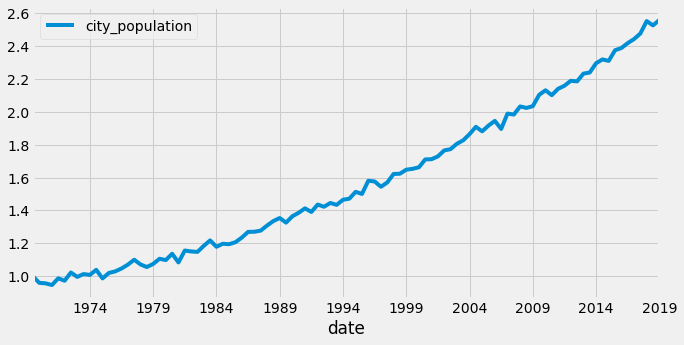

In [25]:
# Run the augmented Dicky-Fuller on the 'city_population' column of city.
result = adfuller(city["city_population"])
# Print the test statistic and the p-value.
print("p value : ",  result[1])
print("test statistic : ", result[0])

# Plot the time series
fig, ax = plt.subplots();
city.plot(ax=ax);


p value :  0.8147894381484768
test statistic :  -0.8146211646182153


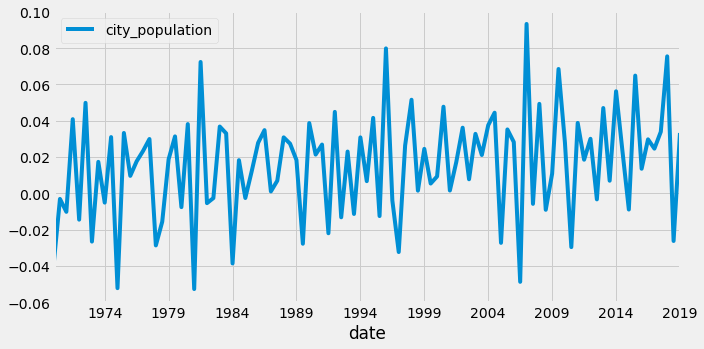

In [24]:
#Take the first difference of city dropping the NaN values. Assign this to city_stationary and run the test again.
city_stationary = city.diff().dropna()
result = adfuller(city_stationary["city_population"])
# Print the test statistic and the p-value.
print("p value : ",  result[1])
print("test statistic : ", result[0])
fig, ax = plt.subplots()
city_stationary.plot(ax=ax)
plt.show()

ADF Statistic: -6.433646032918764
p-value: 1.673449851039826e-08


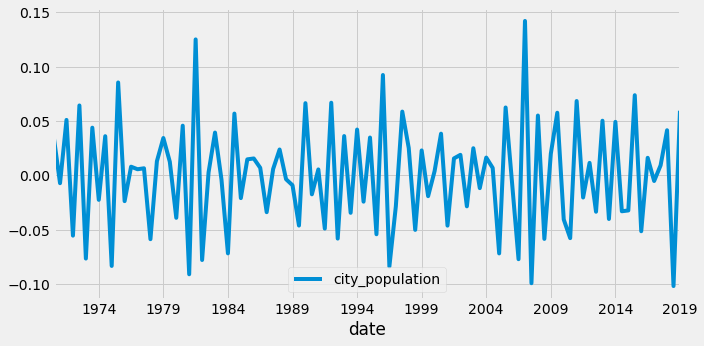

In [28]:
# Calculate the second difference of the time series
city_stationary = city.diff().diff().dropna()

# Run ADF test on the differenced time series
result = adfuller(city_stationary['city_population'])

# Plot the differenced time series
fig, ax = plt.subplots();
city_stationary.plot(ax=ax);

# Print the test statistic and the p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

note: Amazing! A p-value of 0.000000016 is very significant! This time series is now stationary and ready for modeling!

#### 2 C: -  Other tranforms
Differencing should be the first transform you try to make a time series stationary. But sometimes it isn't the best option.

A classic way of transforming stock time series is the log-return of the series. This is calculated as follows:
$$ \log\text{_return} (y_t) = \log \big(\frac{y_t}{y_{t-1}}\big)$$

You can calculate the log-return of this DataFrame by substituting:

$y_t$ → amazon

$y_{t-1}$ → amazon.shift(1)

$\log()$ → ```np.log()```

In this exercise you will compare the log-return transform and the first order difference of the Amazon stock time series to find which is better for making the time series stationary.

In [29]:
amazon = pd.read_csv('./dataset/amazon_close.csv', index_col='date', parse_dates=True)
amazon.head()

,close
date,
2019-02-08,1588.22
2019-02-07,1614.37
2019-02-06,1640.26
2019-02-05,1658.81
2019-02-04,1633.31


In [32]:
# Calculate the first difference of the time series amazon to test for stationarity and drop the NaNs.
amazon_diff = amazon.diff
amazon_diff = amazon_diff().dropna()
result_diff = adfuller(amazon_diff['close'])
print(result_diff)

(-7.2035794888112425, 2.331271725487213e-10, 23, 1234, {'1%': -3.435660336370594, '5%': -2.863885022214541, '10%': -2.568018522153254}, 10764.626718933836)


In [34]:
#Calculate the log return on the stocks time series amazon to test for stationarity.
np.log(amazon)

,close
date,
2019-02-08,7.370369
2019-02-07,7.386700
2019-02-06,7.402610
2019-02-05,7.413856
2019-02-04,7.398364
...,...
2014-02-14,5.878716
2014-02-13,5.878296
2014-02-12,5.855788


 note: Great work! Notice that both the differenced and the log-return transformed time series have a small p-value, but the log transformed time series has a much more negative test statistic. This means the log-return tranformation is better.

#### 3:  Intro to AR, MA and ARMA models
- AR models
    - Autoregressive (AR) model
        - AR(1) model:
$$ y_t = a_1 y_{t-1} + \epsilon_t $$
        - AR(2) model:
$$ y_t = a_1 y_{t-1} + a_2 y_{t-2} + \epsilon_t $$
        - AR(p) model:
$$ y_t = a_1 y_{t-1} + a_2 y_{t-2} + \cdots + a_p y_{t-p} + \epsilon_t $$
- MA models
    - Moving Average (MA) model
        - MA(1) model:
$$ y_t = m_1 \epsilon_{t-1} + \epsilon_t $$
        - MA(2) model:
$$ y_t = m_1 \epsilon_{t-1} + m_2 \epsilon_{t-2} + \epsilon_t $$
        - MA(q) model:
$$ y_t = m_1 \epsilon_{t-1} + m_2 \epsilon_{t-2} + \cdots + m_q \epsilon_{t-q} + \epsilon_t $$ 
- ARMA models
    - Autoregressive moving-average (ARMA) model
    - ARMA = AR + MA
        - ARMA(1, 1) model:
$$ y_t = a_1 y_{t-1} + m_1 \epsilon_{t-1} + \epsilon_t $$
        - ARMA(p, q) model:
            - p is order of AR part
            - q is order of MA part

#### 3: A :-  Model order
When fitting and working with AR, MA and ARMA models it is very important to understand the model order. You will need to pick the model order when fitting. Picking this correctly will give you a better fitting model which makes better predictions. So in this section you will practice working with model order.

In [36]:
ar_coefs = [1, 0.4, -0.1]
ma_coefs = [1, 0.2]

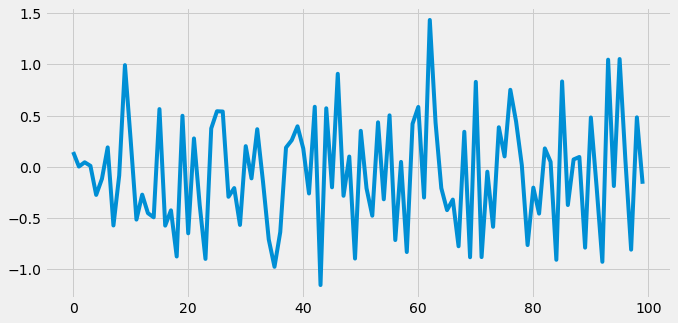

In [37]:
from statsmodels.tsa.arima_process import arma_generate_sample

y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y);

#### 3 B: Generating ARMA data

In this exercise you will generate 100 days worth of AR/MA/ARMA data. Remember that in the real world applications, this data could be changes in Google stock prices, the energy requirements of New York City, or the number of cases of flu.

You can use the arma_generate_sample() function available in your workspace to generate time series using different AR and MA coefficients.

Remember for any model ARMA(p,q):

The list ar_coefs has the form [1, -a_1, -a_2, ..., -a_p].
The list ma_coefs has the form [1, m_1, m_2, ..., m_q],
where a_i are the lag-i AR coefficients and m_j are the lag-j MA coefficients.

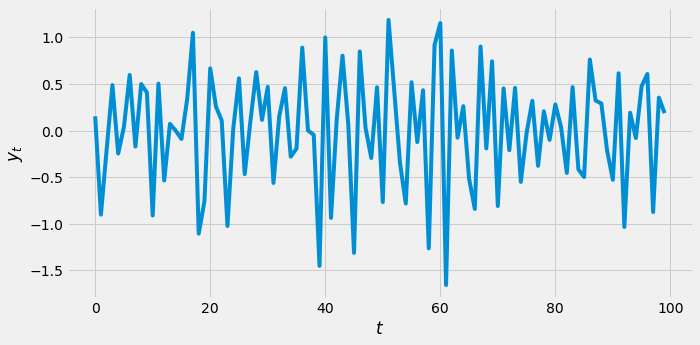

In [45]:
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA

# Set ar_coefs and ma_coefs for an MA(1) model with MA lag-1 coefficient of -0.7.
ar_coefs = [1]
ma_coefs = [1, -0.7]
# Generate a time series of 100 values.
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

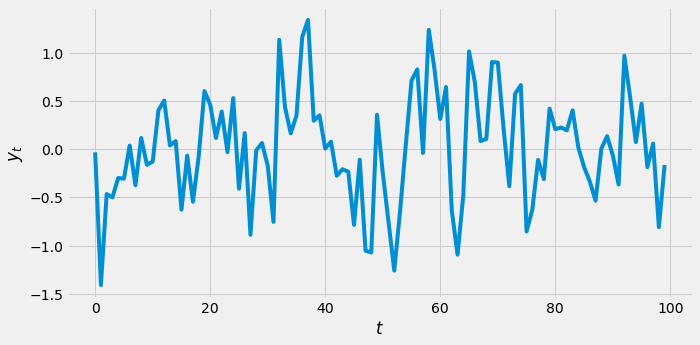

In [46]:
# Set the coefficients for an AR(2) model with AR lag-1 and lag-2 coefficients of 0.3 and 0.2 respectively.
ar_coefs = [1, -0.3, -0.2]
ma_coefs = [1]

y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()


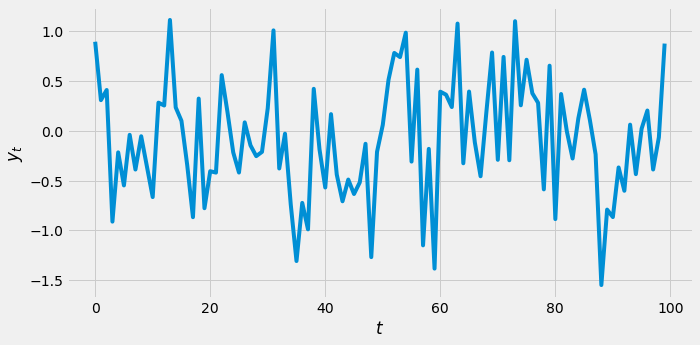

In [47]:
# ARMA model with $y_t = -0.2 y_{t-1} + 0.3 \epsilon_{t-1} + 0.4 \epsilon_{t-2} + \epsilon_t$

np.random.seed(3)

# Set coefficients
ar_coefs = [1, 0.2]
ma_coefs = [1, 0.3, 0.4]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y);
plt.ylabel(r'$y_t$');
plt.xlabel(r'$t$');

note: ARMA-zing work! You can use this data to check our code. If you can recover these same coefficients when you fit a model, then you will know your methods work!

#### 3: C -  Fitting Prelude
Great, you understand model order! Understanding the order is important when it comes to fitting models. You will always need to select the order of model you fit to your data, no matter what that data is.

In this exercise you will do some basic fitting. Fitting models is the next key step towards making predictions. We'll go into this more in the next chapter but let's get a head start.

Some example ARMA(1,1) data have been created and are available in your environment as y. This data could represent the amount of traffic congestion. You could use forecasts of this to suggest the efficient routes for drivers.

In [53]:
# Import the ARMA model class from the statsmodels.tsa.arima_model submodule.
# Create a model object, passing it the time series y and the model order (1,1). Assign this to the variable model.
model = ARIMA(y, order= (1, 0, 1))
# Use the model's .fit() method to fit to the data.
result = model.fit()

In [54]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -85.231
Date:                Sat, 15 Jan 2022   AIC                            178.463
Time:                        17:36:00   BIC                            188.883
Sample:                             0   HQIC                           182.680
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0711      0.085     -0.838      0.402      -0.237       0.095
ar.L1          0.5889      0.336      1.752      0.080      -0.070       1.248
ma.L1         -0.3840      0.391     -0.982      0.326      -1.150       0.382
sigma2         0.3217      0.050      6.377      0.000       0.223       0.421
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                 0.69
Prob(Q):                              0.40   Prob(JB):                         0.71
Heteroskedasticity (H):               1.27   Skew:                            -0.12
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""